# Task 3, Training a Variational Auto-Encoder on MNIST

## 1. Initial Setup

For task 3 we used Pytorch, Numpy and Matplotlib.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2.Define the VAE model

In [2]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, latent_dims)
        self.linear4 = nn.Linear(256, latent_dims)
        self.kl = 0
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu =  self.linear3(x)
        sigma = self.linear4(x)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z
        # return z.reshape((-1, 1, 28, 28))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def reparameterize(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def forward(self, x):
        # print(x)
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        # print('z2:',z)
        x_recon = self.decoder(z)
        # print('xrecon2:',x_recon)
        return x_recon, mu, sigma

    def generate_samples(self, num_samples):
        z = torch.randn(num_samples,latent_dims).to(device)
        samples = self.decoder(z)
        return samples

## 3. Define functions

In [3]:
def elbo_loss(x, x_hat, mu, log_var):
    #Reconstruction
    x=x.view(-1, 784)
    # print('x_recon1:',x_hat)
    x=torch.sigmoid(x)
    # print('x1:',x)
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    #Regularisation
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_div

In [4]:
train_losses = []
def train(autoencoder, data, epochs):
    opt = torch.optim.Adam(autoencoder.parameters(),lr=0.001) # Set up the optimizer
    autoencoder.train()
    # train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x, y in data:
            x = x.view(-1, 784).to(device) # CPU
            # print('x2:',x.shape)
            # print('x2:',x)
            opt.zero_grad()
            # x_hat= autoencoder(x)
            x_hat, mu, logvar = autoencoder(x)
            # print('x_recon2:',x_hat.shape)
            # print(mu.shape)
            # print(logvar.shape)
            # loss = ((x - x_hat)**2).sum()+ autoencoder.encoder.kl
            loss =elbo_loss(x, x_hat, mu, logvar)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss:.4f}')
        total_loss = total_loss / len(data.dataset)
        train_losses.append(total_loss)
    return autoencoder
test_losses = []
def test(autoencoder, data, epochs):
    # autoencoder.eval()
    with torch.no_grad():
        for epoch in range(epochs):
            autoencoder.eval()
            epoch_loss = 0.0
            for x, y in data:
                x = x.to(device) # CPU
                x_hat,mu, logvar = autoencoder(x)
                # x_hat = autoencoder(x)
                loss =elbo_loss(x, x_hat, mu, logvar)
                epoch_loss +=  loss.item()
            epoch_loss = epoch_loss / len(data.dataset)
            test_losses.append(epoch_loss)
    return test_losses

In [6]:
#plot the latent representation
def plot_latent(autoencoder, data, num_batches=128):
    for i, (x, y) in enumerate(data): 
        x = x.view(-1,784).to(device)
        z,j = autoencoder.encoder(x)
        z = z.to('cpu').detach().numpy() 
        # latent_vectors.append(z.cpu().numpy()) 
        # labels.append(y.numpy())
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10') 
    plt.colorbar()
    plt.title('Latent Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')

In [7]:
#plot reconstructed digits and the corresponding original ones
def plot_reconstructed(autoencoder, data, num_digits=15):
    for batch in data:
        x, y = batch
        break 
    x = x.to(device) 
    z,i,j = autoencoder(x)
    x = x.view(-1, 28, 28).cpu().numpy() 
    z = z.view(-1, 28, 28).cpu().detach().numpy()  
    #Original Digits
    fig, axes = plt.subplots(3, 5,figsize=(8, 4))
    for i in range(15):
        row = i // 5  # Calculate the row index
        col = i % 5   # Calculate the column index
        axes[row, col].imshow(x[i])  # Display the image
        axes[row, col].axis('off')   
    plt.suptitle('Original Digits')
    
    #Reconstructed Digits
    fig, axes = plt.subplots(3, 5,figsize=(8, 4))
    for i in range(15):
        row = i // 5  # Calculate the row index
        col = i % 5   # Calculate the column index
        axes[row, col].imshow(z[i])  # Display the image
        axes[row, col].axis('off') 
    plt.suptitle('Reconstructed Digits')
    plt.show()

In [8]:
#plot generated digits
def plot_generated(autoencoder, num_samples=15):
    z = autoencoder.generate_samples(num_samples) 
    z = z.view(-1, 28, 28).cpu().detach().numpy() 

    fig, axes = plt.subplots(3, 5,figsize=(8, 4))
    for i in range(15):
        row = i // 5  # Calculate the row index
        col = i % 5   # Calculate the column index
        axes[row, col].imshow(z[i])  # Display the image
        axes[row, col].axis('off') 
    plt.suptitle('Generated Digits')
    plt.show()

In [9]:
def plot_losses(train_losses,test_losses,epochs):
    plt.figure(figsize=(8, 6))
    print('Train Loss',train_losses)
    print('Test Loss',test_losses)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss (Negative ELBO)')
    plt.title('Test Loss Curve')
    plt.legend()
    plt.show()

## 4.Dataset
Load the MNIST dataset and create data loaders

In [10]:
train_data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
                                   train=True,
               transform=torchvision.transforms.Compose([
                         torchvision.transforms.ToTensor(), # first, convert image to PyTorch tensor
                         torchvision.transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                ]),
               download=True),
        batch_size=128,
        shuffle=True)

test_data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
                                   train=False,
               transform=torchvision.transforms.Compose([
                         torchvision.transforms.ToTensor(), # first, convert image to PyTorch tensor
                         torchvision.transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs, mean=mean/255, std=std/255
                ]),
               download=True),
        batch_size=128,
        shuffle=False)

## 5. Training and Visualization

In [12]:
latent_dims = 2 # Dimension of the latent space
vae = VariationalAutoencoder(latent_dims).to(device)

Epoch 1/50, Train Loss: 31330563.3594
Epoch 2/50, Train Loss: 31113154.8125
Epoch 3/50, Train Loss: 31055583.6523
Epoch 4/50, Train Loss: 31020618.7031
Epoch 5/50, Train Loss: 30996414.8945
Epoch 6/50, Train Loss: 30978443.2617
Epoch 7/50, Train Loss: 30962765.2188
Epoch 8/50, Train Loss: 30952981.7383
Epoch 9/50, Train Loss: 30941770.8789
Epoch 10/50, Train Loss: 30932084.1211
Epoch 11/50, Train Loss: 30924952.4336
Epoch 12/50, Train Loss: 30919615.7734
Epoch 13/50, Train Loss: 30913564.0977
Epoch 14/50, Train Loss: 30906919.8984
Epoch 15/50, Train Loss: 30904208.1289
Epoch 16/50, Train Loss: 30901517.7383
Epoch 17/50, Train Loss: 30898140.0078
Epoch 18/50, Train Loss: 30893206.3711
Epoch 19/50, Train Loss: 30891660.2969
Epoch 20/50, Train Loss: 30886867.8711
Epoch 21/50, Train Loss: 30885085.6250
Epoch 22/50, Train Loss: 30882781.4570
Epoch 23/50, Train Loss: 30881734.4883
Epoch 24/50, Train Loss: 30878930.6250
Epoch 25/50, Train Loss: 30877121.2734
Epoch 26/50, Train Loss: 30877167.

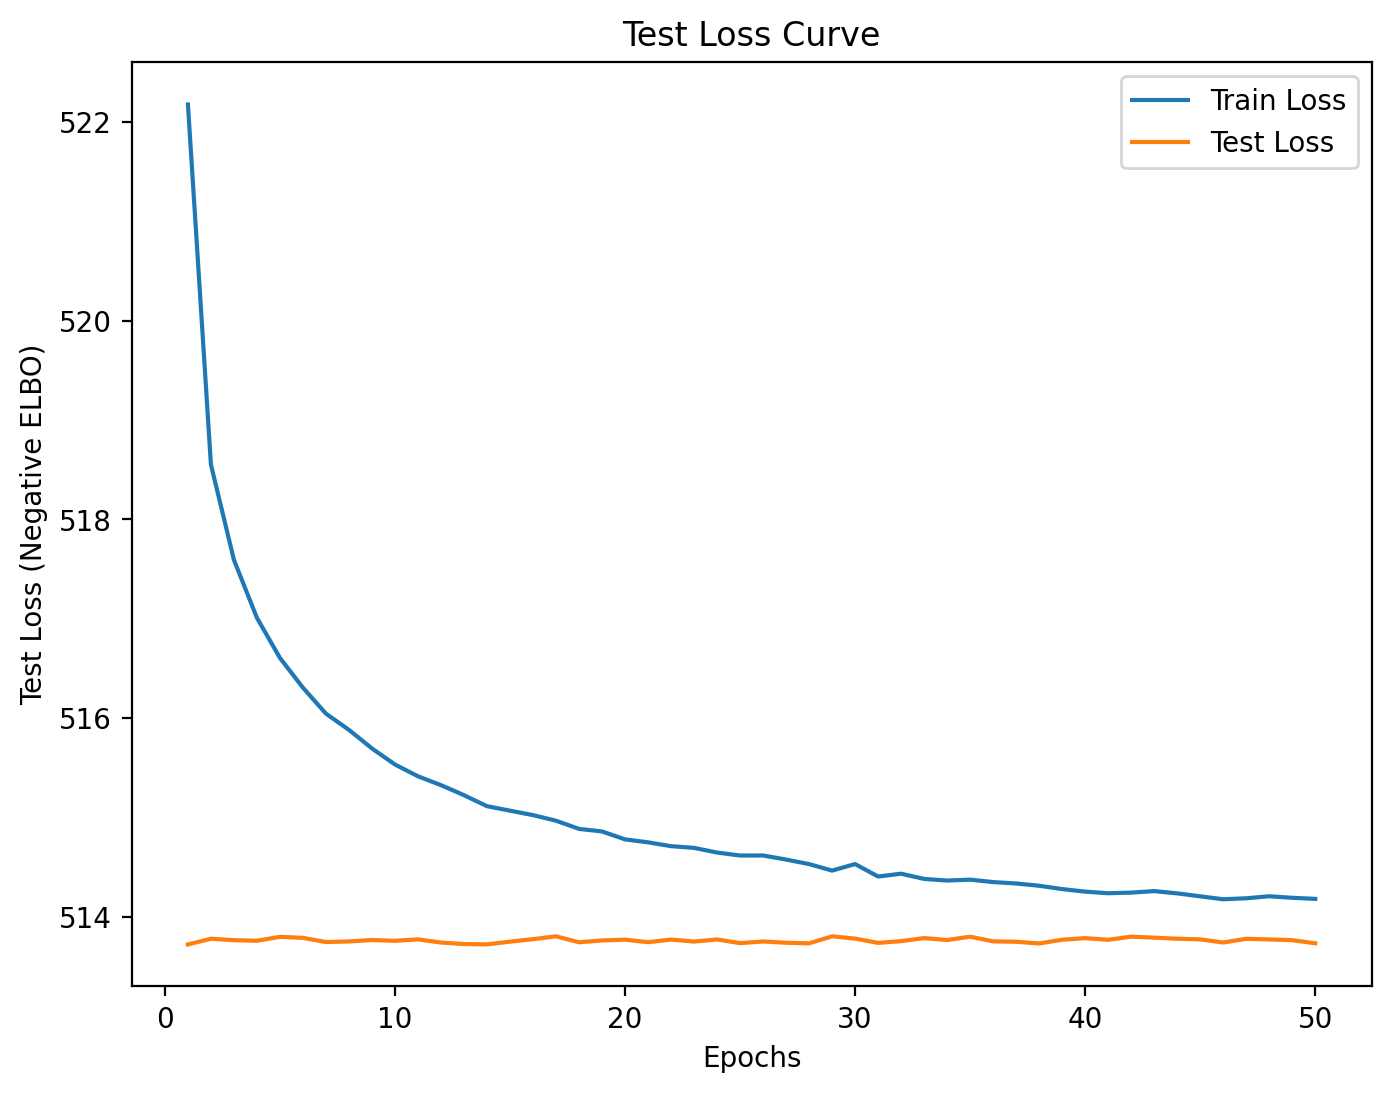

In [14]:
# plot_latent(vae, test_data)
epochs = 50
vae= train(vae, train_data,epochs)
# vae= train(vae, test_data,epochs)

test_losses = test(vae, test_data, epochs)
print('test',len(train_losses))
print('train',len(test_losses))
plot_losses(train_losses,test_losses,epochs)